In [1]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as tf
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
%matplotlib inline

from text2img_model import Text2ImgEvalModel
from data_utils import BirdsPreprocessor, CaptionTokenizer, BirdsDataset, prepare_data
from data_utils import CocoPreprocessor, CocoDataset

def save_images(images, save_dir, save_size=256, filenames=None):
    num_images = images.size(0)
    folder = os.path.join(save_dir, 'images')
    os.makedirs(folder, exist_ok=True)

    if filenames is None:
        filenames = [str(i) for i in range(num_images)]

    for i in range(num_images):
        im = images[i].detach().cpu()
        fullpath = os.path.join(folder, filenames[i]+'.jpg')
        # [-1, 1] --> [0, 1]
        img = im.add(1).div(2).mul(255).clamp(0, 255).byte()
        # [0, 1] --> [0, 255]
        ndarr = img.permute(1, 2, 0).data.cpu().numpy()
        im = Image.fromarray(ndarr)
        im = tf.functional.resize(im, save_size)
        im.save(fullpath)
        
def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [2]:
# You probably don't want to change parameters in the first group
params = {
    # Group 1: fixed parameters
    'embedding_dim': 256,
    'text_encoder_embd_size': 128,
    'z_dim': 100,
    'num_generator_filters': 32,
    'branch_num': 3,
    # Group 2: variable parameters    
    'pretrained_generator_path': None,#'trained_models/BCE_final_lambda_3/30:05:2019:14-07-10/avg_weights48000.pt',
    'pretrained_text_encoder_path': None,#'trained_models/DAMSM/Loss_8-36_28:05:2019:15-13-53/best_text_encoder.pt',
    'pretrained_ckpt': 'trained_models/BCE/part2/weights98000.pt',
    'condition_dim': 128,
    'is_bert_encoder': False,
    'use_sagan': False,
    'base_size': 64, #32
    'device': torch.device('cuda')
}

In [3]:
MODEL_NAME = 'some_model'
EXP_PATH = os.path.join(os.getcwd(), 'evaluation', MODEL_NAME)
TYPE = 'birds'

if TYPE == 'birds':
    PATH = 'dataset/CUB_200_2011'
elif TYPE == 'coco':
    PATH = ''

if TYPE == 'birds':
    preproc = BirdsPreprocessor(data_path=PATH, dataset_name='cub')
    tokenizer = CaptionTokenizer(
        word_to_idx=preproc.word_to_idx,
        idx_to_word=preproc.idx_to_word
    )
    dataset = BirdsDataset(
        mode='test', tokenizer=tokenizer, preprocessor=preproc,
        branch_num=params['branch_num'], base_size=params['base_size']
    )
elif TYPE == 'coco':
    preproc = CocoPreprocessor(data_path=PATH, dataset_name='coco')
    tokenizer = CaptionTokenizer(
        word_to_idx=preproc.word_to_idx,
        idx_to_word=preproc.idx_to_word
    )
    dataset = CocoDataset(
        mode='test', tokenizer=tokenizer, preprocessor=preproc,
        branch_num=params['branch_num'], base_size=params['base_size']
    )

In [4]:
model = Text2ImgEvalModel(n_tokens=dataset.n_tokens, **params)

Loading from checkpoint


In [5]:
def get_captions_and_save(n_batches, batch_size):
    iterator = iter(DataLoader(dataset, batch_size, shuffle=True, drop_last=True))
    captions = []

    for i in range(n_batches):
        val_data = next(iterator)
        val_img, val_cap, val_cap_len, val_mask, _ = \
            prepare_data(val_data, params['device'])
        captions += dataset.tensor_to_caption(val_cap)

        val_noise = torch.FloatTensor(
            val_cap.size(0),
            params['z_dim']
        ).to(params['device']).normal_(0, 1)

        gen_imgs_stack, _, _, _, _ = \
            model(
                val_cap,
                val_cap_len,
                val_noise,
                val_mask
            )

        for j, gen_imgs in enumerate(gen_imgs_stack):
            size = 64*(2**j)
            filenames = ['%03d_%03d'%(i*batch_size+k, size) for k in range(1, batch_size+1)]
            save_images(gen_imgs, EXP_PATH, 256, filenames)

    caption_path = os.path.join(EXP_PATH, 'image_captions.txt')
    with open(caption_path, 'w') as f:
        f.writelines(
            "\n".join(["%d."%(i+1)+cap for i, cap in enumerate(captions)])
        )

In [6]:
N = 5
BS = 5
# generate N*BS images and save to EXP_PATH
get_captions_and_save(N, BS)

In [7]:
def generate_images(captions):
    captions_t, caption_lengths = zip(*map(tokenizer.get_padded_tensor, captions))
    captions_t = torch.cat([cap.unsqueeze(0) for cap in captions_t], 0)
    captions_t = captions_t.to(params['device'])
    caption_lengths = torch.LongTensor(caption_lengths)
    mask = torch.ne(captions_t, 0).to(params['device'])

    noise = torch.FloatTensor(
        captions_t.size(0),
        params['z_dim']
    ).to(params['device']).normal_(0, 1)

    gen_imgs_stack, _, _, _, _ = \
        model(
            captions_t,
            caption_lengths,
            noise,
            mask
        )

    for i, gen_imgs in enumerate(gen_imgs_stack):
        img_tensor = gen_imgs.add(1).div(2).detach().cpu()
        img_tensor = make_grid(img_tensor, nrow=len(captions), padding=4)
        plt.figure(figsize=(15, 5))
        show(img_tensor)

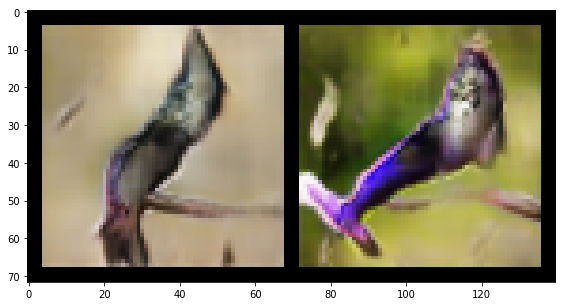

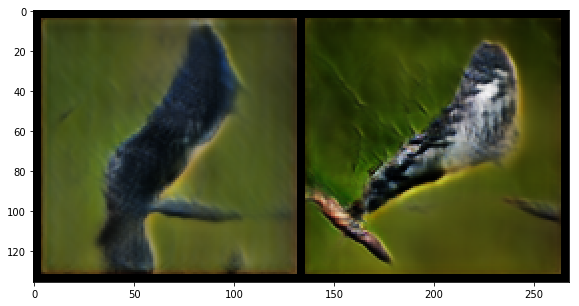

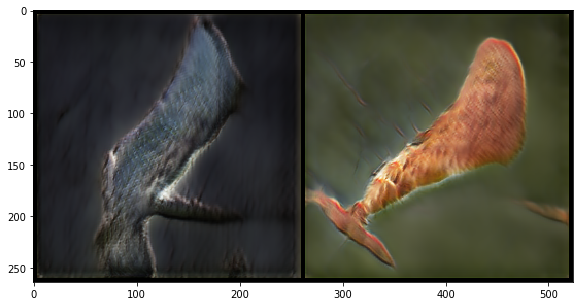

In [16]:
# please sort captions in a descending order by the number of words
# or use one caption at a time
captions = [
    'blue bird',
    'red bird'
]
generate_images(captions)